In [1]:
import os
import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import torchvision.models as models
from PIL import Image
from glob import glob
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.nn.utils.rnn import pack_padded_sequence

%matplotlib inline

In [2]:
use_cuda = torch.cuda.is_available()
if not use_cuda:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
device = torch.device("cuda" if use_cuda else "cpu")

CUDA is available!  Training on GPU ...


In [3]:
total_files = np.array(glob("Dataset/Abstract_Scenes/*/*/*"))
print('There are %d total images.' % len(total_files))

There are 50001 total images.


In [4]:
data_dir = "Dataset/Abstract_Scenes/"
train_path = "Training images/"
val_path = "Validation images/"
test_path = "Testing images/"

In [5]:
def get_dataloader(batch_size, image_size, data_dir='Dataset/Abstract_Scenes'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    transform = transforms.Compose([transforms.Resize(image_size),
                                   transforms.ToTensor()])
    
    image_path = './' + data_dir
    
    datasett = datasets.ImageFolder(image_path, transform)
    
    loader = DataLoader(dataset=datasett, batch_size=batch_size, shuffle=True)
    return loader

In [6]:
### Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
valid_size=0.2

train_transform = transforms.Compose([
#                               transforms.RandomResizedCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                        std=[0.229, 0.224, 0.225])])
valid_transform = transforms.Compose([transforms.Resize(256),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                        std=[0.229, 0.224, 0.225])])
test_transform = transforms.Compose([transforms.Resize(size=(224,224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                        std=[0.229, 0.224, 0.225])])

train_data = datasets.ImageFolder(root = data_dir + train_path, transform=train_transform)
valid_data = datasets.ImageFolder(root = data_dir + val_path, transform=valid_transform)
test_data = datasets.ImageFolder(root= data_dir + test_path, transform=test_transform)

# print number of images in each dataset
print('There are %d train images.' % len(train_data))
print('There are %d validation images.' % len(valid_data))
print('There are %d test images.' % len(test_data))


trainloader = torch.utils.data.DataLoader(train_data, batch_size=20,shuffle=False)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=20,shuffle=False)
testloader = torch.utils.data.DataLoader(test_data, batch_size=20, shuffle=False)

loaders_scratch = dict(train=trainloader,
                       valid = validloader,
                       test=testloader)

There are 20000 train images.
There are 10000 validation images.
There are 20000 test images.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

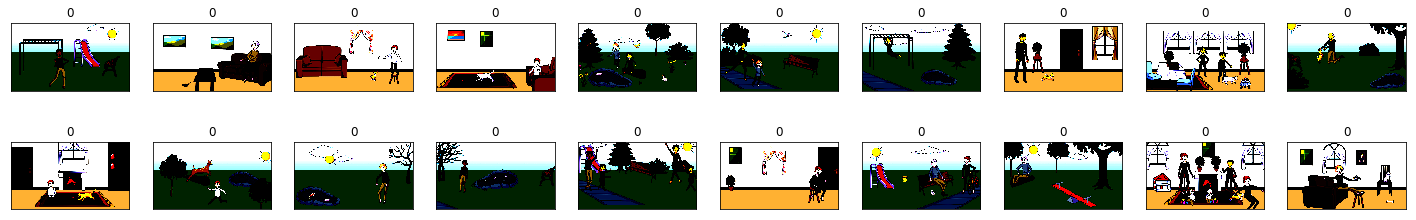

In [7]:
# obtain one batch of training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.transpose(images[idx], (1, 2, 0)))
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

In [8]:
# import torchvision.models as models
# import torch.nn as nn

# ## TODO: Specify model architecture 
# model_transfer = models.vgg16(pretrained=True)
# print(model_transfer)

In [10]:
# def get_transform(target_size, central_fraction=1.0):
#     return transforms.Compose([
#         transforms.Scale(int(target_size / central_fraction)),
#         transforms.CenterCrop(target_size),
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                              std=[0.229, 0.224, 0.225]),
#     ])

# class ResNetLayer4(torch.nn.Module):
#     def __init__(self):
#         super(ResNetLayer4, self).__init__()
#         self.model = resnet.resnet152(pretrained=True)
        
#         # from  visual_qa_analysis/config.py
#         image_size = 448  # scale shorter end of image to this size and centre crop
#         #output_size = image_size // 32  # size of the feature maps after processing through a network
#         output_features = 2048  # number of feature maps thereof
#         central_fraction = 0.875 # only take this much of the centre when scaling and centre cropping

#         self.transform = get_transform(image_size, central_fraction)

#         def save_output(module, input, output):
#             self.buffer = output
#         self.model.layer4.register_forward_hook(save_output)

#     def forward(self, x):
#         self.model(x)
#         return self.buffer
    
#     def image_to_features(self, img_file):
#         img = Image.open(img_file).convert('RGB')
#         img_transformed = self.transform(img)
#         #print(img_transformed.size())
#         img_batch = img_transformed.unsqueeze(0).to(device)
#         return self.forward(img_batch) 
    
# resnet_layer4 = ResNetLayer4().to(device)  # Downloads 241Mb model when first run